# FAIRNESS AWARE CLASSIFICATION DEMO

In [7]:
from __future__ import print_function, division
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import multivariate_normal
import seaborn as sns; sns.set()
from demo import fairness_demo

## logistic regression with fairness constraints

In [11]:
### this function returns a set of normally distributed points
def get_gaussian_data(mean, cov, class_label, n_samples):
    nv = multivariate_normal(mean = mean, cov = cov)
    X = nv.rvs(n_samples)
    y = np.ones(n_samples, dtype=float) * class_label
    return X,y

### here we define our three datasets. for each there are 2 target classes (+1 and -1), 
### 2 non-sensitive covariates, and 1 sensitive covariate. 
### each dataset has N=300 datapoints
### X is a N x 2 matrix
### y is a length N column vector containing the target labels +-1
### x_sensitive is a length N column vector that contains the protected class membership (0 corresponds to the protected class)

### this function returns a dataset where discrimination is a huge problem
def get_dataset1():
    np.random.seed(129)
    mu1, sigma1 = [2, 2], [[5, 1], [1, 5]]
    mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
    X1, y1 = get_gaussian_data(mu1, sigma1, 1, 150) # positive class
    X2, y2 = get_gaussian_data(mu2, sigma2, -1, 150) # negative class
    X = np.vstack((X1, X2)) # non-sensitive covariates
    y = np.hstack((y1, y2)) # class labels
    x_sensitive = (X[:,0]-np.mean(X[:,0])+.3*X[:,1]**2-0.3)/(5*X[:,1]**2+0.1)
    x_sensitive = 0.5*(1+np.tanh(x_sensitive))
    x_sensitive = np.round(x_sensitive) # sensitive covariate
    return X, y, x_sensitive

### this function returns a dataset where the protected class is quite small
def get_dataset2():
    np.random.seed(129)
    mu1, sigma1 = [2, 2], [[5, 1], [1, 5]]
    mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
    X1, y1 = get_gaussian_data(mu1, sigma1, 1, 150) # positive class
    X2, y2 = get_gaussian_data(mu2, sigma2, -1, 150) # negative class
    X = np.vstack((X1, X2)) # non-sensitive covariates
    y = np.hstack((y1, y2)) # class labels
    x_sensitive = 1-np.logical_and(X[:,0]<0.0, X[:,1]>0.0)
    x_sensitive = np.asarray(pd.DataFrame(x_sensitive).applymap(float)).reshape(1,len(x_sensitive))[0] # sensitive covariate
    return X, y, x_sensitive

### this function returns a dataset where the protected class membership is uncorrelated with anything else
def get_dataset3():
    np.random.seed(129)
    mu1, sigma1 = [2, 2], [[5, 1], [1, 5]]
    mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
    X1, y1 = get_gaussian_data(mu1, sigma1, 1, 150) # positive class
    X2, y2 = get_gaussian_data(mu2, sigma2, -1, 150) # negative class
    X = np.vstack((X1, X2)) # non-sensitive covariates
    y = np.hstack((y1, y2)) # class labels
    x_sensitive = np.ones(300)
    x_sensitive[np.random.choice(300, 150, replace=False)] = 0 # sensitive covariate
    return X, y, x_sensitive

### this function trains both a constrained and unconstrained classifier for the given dataset
### and plots the results as well as prints out some summary statistics, the accuracy, etc
def train_and_plot(X,y,x_sensitive,fairness_constraint):
    fd_unconstrained=fairness_demo(); 
    fd_constrained=fairness_demo(); 

    ### here we train the unconstrained classifier (as specified by the final argument of -1.0)
    ### the train function returns the following:
    ### w = the vector of weights that defines the decision boundary
    ### p_rule = the p%-rule ratio that quantifies adverse impact to the protected class
    ### accuracy = the prediction accuracy of the classifier on the training set w.r.t. the target labels
    w_unconstrained, p_rule_unconstrained, accuracy_unconstrained = fd_unconstrained.train(X,y,x_sensitive,-1.0)  

    ### here we train the fairness-constrained classifier (as specified by the final argument)
    w_constrained, p_rule_constrained, accuracy_constrained = fd_constrained.train(X,y,x_sensitive,fairness_constraint)

    fig, ((axA, axB)) = plt.subplots(nrows=1, ncols=2,figsize=(12,8))
    print("dataset size:  %d" % len(x_sensitive))
    print("number of protected members:  %d" % (len(x_sensitive)-np.sum(x_sensitive)))
    print("w_unconstrained: ",w_unconstrained)
    print("w_constrained:   ",w_constrained)
    print("p_rule_unconstrained:    %2.1f%%    p_rule_constrained:    %2.1f%%" % (p_rule_unconstrained,p_rule_constrained))
    print("accuracy_unconstrained:  %2.1f%%    accuracy_constrained:  %2.1f%%" % (accuracy_unconstrained, accuracy_constrained))
    fd_unconstrained.plot(axA)
    fd_constrained.plot(axB)

dataset size:  300
number of protected members:  95
w_unconstrained:  [-0.09795125  0.39948066  0.83078741]
w_constrained:    [ 0.1327356  -0.20500078  0.56553333]
p_rule_unconstrained:    9.1%    p_rule_constrained:    74.0%
accuracy_unconstrained:  87.7%    accuracy_constrained:  73.7%


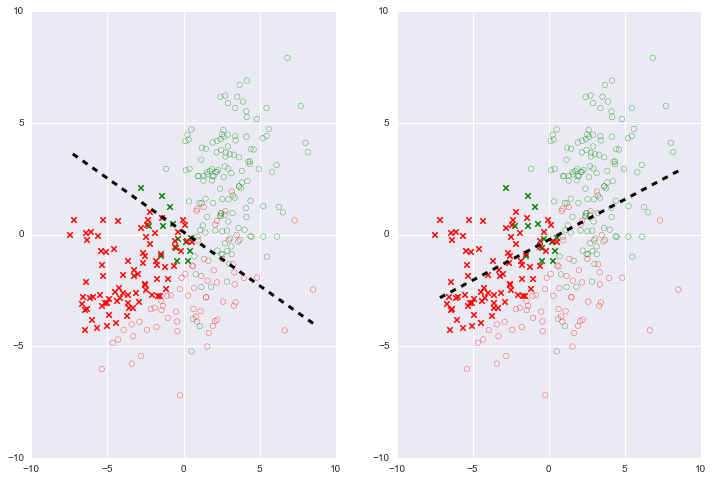

In [12]:
train_and_plot(*get_dataset1(),fairness_constraint=0.01)

dataset size:  300
number of protected members:  20
w_unconstrained:  [-0.09795125  0.39948066  0.83078741]
w_constrained:    [-0.00799004  0.31678048  0.88668084]
p_rule_unconstrained:    58.7%    p_rule_constrained:    90.0%
accuracy_unconstrained:  87.7%    accuracy_constrained:  87.7%


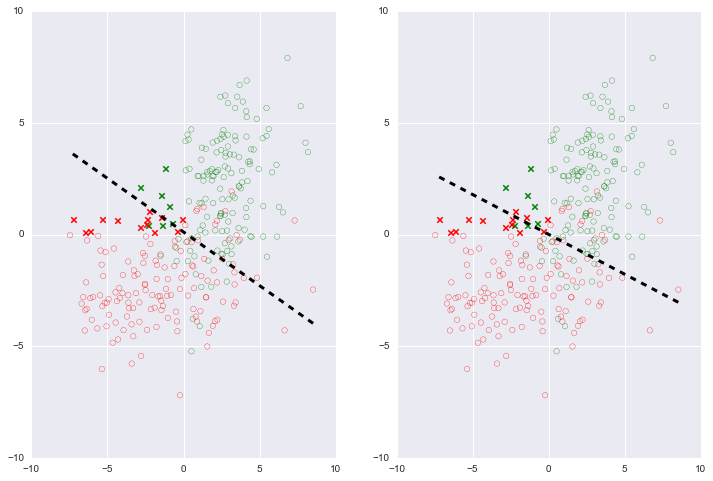

In [13]:
train_and_plot(*get_dataset2(),fairness_constraint=0.02)

dataset size:  300
number of protected members:  150
w_unconstrained:  [-0.09807296  0.39953552  0.83080192]
w_constrained:    [-0.04148338  0.34957908  0.86679336]
p_rule_unconstrained:    98.7%    p_rule_constrained:    96.0%
accuracy_unconstrained:  87.7%    accuracy_constrained:  87.7%


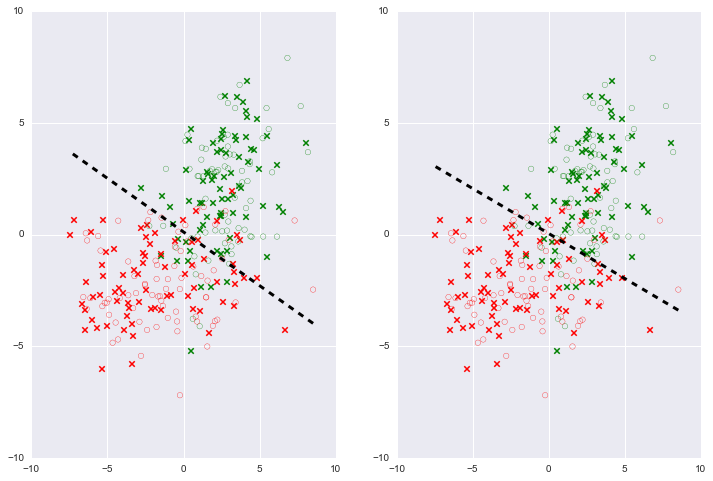

In [14]:
train_and_plot(*get_dataset3(),fairness_constraint=0.01)